# prj :  Spectrogram classification 모델 구현

- 2차원 데이터 받아 
- 기본버전과 skip connection 버전 모델 실습


## import library

In [41]:
import numpy as np
import os
import matplotlib.pyplot as plt

import IPython.display as ipd
import random

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras import layers

import librosa

In [42]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## data load

In [43]:
data_path = os.getenv("HOME")+'/aiffel/AIFFEL_LSG/utill/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [44]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)


Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


## 데이터 처리와 분류

###   2차원 Spectrogram 변형`

In [45]:
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [46]:
speech_data["wav_vals"].shape

(50620, 8000)

In [47]:


spec_data = []
for idx, data in enumerate(speech_data["wav_vals"]):
    if idx == 30000: break
    spec = wav2spec(data)
    spec_data.append(spec)

spec_data = np.array(spec_data)




In [48]:
type(spec_data)

numpy.ndarray

In [49]:
print("Wave data shape : ", spec_data.shape)


Wave data shape :  (30000, 130, 126)


### label data 처리

In [50]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

In [51]:
temp = []

for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)


In [52]:
label_value

{'yes': 0,
 'no': 1,
 'up': 2,
 'down': 3,
 'left': 4,
 'right': 5,
 'on': 6,
 'off': 7,
 'stop': 8,
 'go': 9,
 'unknown': 10,
 'silence': 11}

### data set 분리

In [53]:
from sklearn.model_selection import train_test_split

train_wav, test_wav, train_label, test_label = train_test_split(spec_data, 
                                                                label_data[:30000], 
                                                                test_size=0.1,
                                                                shuffle=True)
#print(train_wav)



In [54]:
# train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
# test_wav = test_wav.reshape([-1, sr, 1])
# print("✅")

In [55]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (27000, 130, 126)
train labels :  (27000,)
test data :  (3000, 130, 126)
test labels :  (3000,)
✅


## 학습 하이퍼 파리미터 설정

In [56]:
batch_size = 12
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/utill/checkpoint/wav-spec'

checkpoint_dir

'/home/aiffel0042/aiffel/AIFFEL_LSG/utill/checkpoint/wav-spec'

## dataset 구성

In [57]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label


In [58]:
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)


<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>


##  model 

- 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
- batchnorm, dropout, dense layer 등을 이용
- 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
- 모델 가중치를 저장하는 checkpoint callback 함수 추가


### 일반 모델

In [59]:
# from tensorflow.keras import layers

# input_tensor = layers.Input(shape=(130, 126, 1)) ## TODO

# x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
# x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
# x = layers.MaxPool1D()(x)

# x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
# x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
# x = layers.MaxPool1D()(x)

# x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
# x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
# x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
# x = layers.MaxPool1D()(x)

# x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
# x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
# x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
# x = layers.MaxPool1D()(x)
# x = layers.Dropout(0.3)(x)

# x = layers.Flatten()(x)
# x = layers.Dense(256)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)

# output_tensor = layers.Dense(12)(x)

# model_wav = tf.keras.Model(input_tensor, output_tensor)

# model_wav.summary()

In [60]:
input_tensor = layers.Input(shape=(130, 126, 1)) ## TODO

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 31, 64)       

In [61]:
##### loss #######
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [22]:
## train

# check point 저장
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                  verbose=1)


#30분 내외 소요
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
)

Epoch 1/10
2250/2250 [==============================] - ETA: 0s - loss: 0.7413 - accuracy: 0.7526
Epoch 00001: val_loss improved from inf to 0.29685, saving model to /home/aiffel0042/aiffel/AIFFEL_LSG/utill/speech_recognition/checkpoint/wav-spec
2250/2250 [==============================] - 231s 103ms/step - loss: 0.7413 - accuracy: 0.7526 - val_loss: 0.2969 - val_accuracy: 0.9107
Epoch 2/10
2250/2250 [==============================] - ETA: 0s - loss: 0.2537 - accuracy: 0.9187
Epoch 00002: val_loss improved from 0.29685 to 0.20521, saving model to /home/aiffel0042/aiffel/AIFFEL_LSG/utill/speech_recognition/checkpoint/wav-spec
2250/2250 [==============================] - 225s 100ms/step - loss: 0.2537 - accuracy: 0.9187 - val_loss: 0.2052 - val_accuracy: 0.9357
Epoch 3/10
2250/2250 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.9446
Epoch 00003: val_loss improved from 0.20521 to 0.20123, saving model to /home/aiffel0042/aiffel/AIFFEL_LSG/utill/speech_recognition/

## 학습 그래프 출력

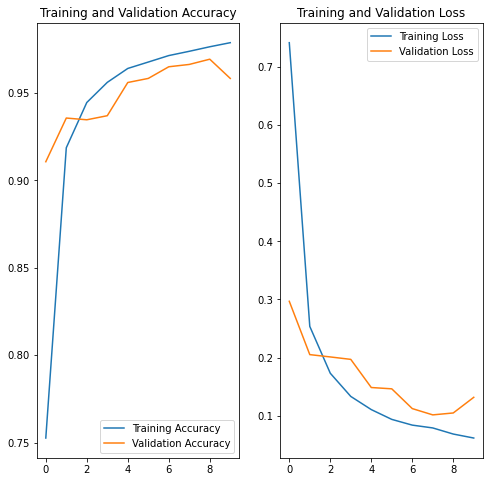

✅


In [23]:

import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

## 성능평가

In [24]:

results = model_wav.evaluate(test_dataset)


250/250 [==============================] - 6s 23ms/step - loss: 0.1318 - accuracy: 0.9583


In [25]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))


loss value: 0.132
accuracy value: 95.8333%


## conv2d 로변경

In [62]:
input_tensor = layers.Input(shape=(130, 126, 1)) ## TODO

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 31, 64)       

In [63]:
batch_size = 12
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/utill/checkpoint/wav-spec-2'

checkpoint_dir

'/home/aiffel0042/aiffel/AIFFEL_LSG/utill/checkpoint/wav-spec-2'

In [64]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])


In [65]:

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                  verbose=1)



In [66]:

#30분 내외 소요
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
)

Epoch 1/10
2250/2250 [==============================] - ETA: 0s - loss: 0.7725 - accuracy: 0.7379
Epoch 00001: val_loss improved from inf to 0.31124, saving model to /home/aiffel0042/aiffel/AIFFEL_LSG/utill/checkpoint/wav-spec-2
2250/2250 [==============================] - 214s 95ms/step - loss: 0.7725 - accuracy: 0.7379 - val_loss: 0.3112 - val_accuracy: 0.9013
Epoch 2/10
2250/2250 [==============================] - ETA: 0s - loss: 0.2485 - accuracy: 0.9229
Epoch 00002: val_loss improved from 0.31124 to 0.21132, saving model to /home/aiffel0042/aiffel/AIFFEL_LSG/utill/checkpoint/wav-spec-2
2250/2250 [==============================] - 216s 96ms/step - loss: 0.2485 - accuracy: 0.9229 - val_loss: 0.2113 - val_accuracy: 0.9287
Epoch 3/10
2250/2250 [==============================] - ETA: 0s - loss: 0.1715 - accuracy: 0.9466
Epoch 00003: val_loss improved from 0.21132 to 0.14696, saving model to /home/aiffel0042/aiffel/AIFFEL_LSG/utill/checkpoint/wav-spec-2
2250/2250 [======================

In [67]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

NameError: name 'model_wav_skip' is not defined

In [ ]:

import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")